In [86]:
import h5py
import numpy as np
from PIL import Image
import os
import matplotlib.pyplot as plt

# 讀取.h5檔案
file_path = "usps.h5"  # 您的檔案路徑
output_folder = "usps_images"  # 輸出資料夾

# 創建輸出目錄結構
os.makedirs(output_folder, exist_ok=True)
for dataset in ["train", "test"]:
    for digit in range(10):
        os.makedirs(os.path.join(output_folder, dataset, str(digit)), exist_ok=True)

# 開啟.h5檔案並提取圖片
with h5py.File(file_path, "r") as f:
    # 處理訓練集和測試集
    for dataset in ["train", "test"]:
        # 獲取資料和標籤
        data = f[f"{dataset}/data"][:]
        labels = f[f"{dataset}/target"][:]
        
        print(f"{dataset} 資料形狀: {data.shape}, 標籤形狀: {labels.shape}")
        
        # 對於每張圖片
        for i in range(len(data)):
            img = data[i]
            label = int(labels[i])  # 確保標籤是整數
            
            # 將標準化的0-1值轉換為0-255值
            img_scaled = (img * 255).astype(np.uint8)
            
            # 將圖片重塑為正方形（如果需要）
            if len(img.shape) == 1:
                # 猜測圖片的維度（假設是正方形）
                img_size = int(np.sqrt(img.shape[0]))
                img_scaled = img_scaled.reshape(img_size, img_size)
            
            # 創建PIL圖片
            img_pil = Image.fromarray(img_scaled)
            
            # 保存路徑
            save_path = os.path.join(output_folder, dataset, str(label), f"image_{i}.png")
            
            # 保存圖片
            img_pil.save(save_path)
            
            # 為每個數字類別生成少量預覽（每個類別的前3張）
            digit_count = sum(1 for j in range(i) if int(labels[j]) == label)
            if digit_count < 3:
                preview_folder = os.path.join(output_folder, "previews", dataset, str(label))
                os.makedirs(preview_folder, exist_ok=True)
                
                plt.figure(figsize=(3, 3))
                plt.imshow(img.reshape(img_size, img_size) if len(img.shape) == 1 else img, cmap='gray')
                plt.title(f"{dataset} - 數字 {label}")
                plt.axis('off')
                plt.savefig(os.path.join(preview_folder, f"preview_{digit_count}.png"))
                plt.close()
        
        print(f"已完成{dataset}集的處理，共{len(data)}張圖片")

print(f"所有圖片已保存到 {output_folder} 資料夾")


train 資料形狀: (7291, 256), 標籤形狀: (7291,)


/var/folders/j6/pkpjgg_54_7_2n3cckcrx4dc4tt_t5/T/ipykernel_70115/2134163160.py:60: UserWarning: Glyph 25976 (\N{CJK UNIFIED IDEOGRAPH-6578}) missing from current font.
  plt.savefig(os.path.join(preview_folder, f"preview_{digit_count}.png"))
/var/folders/j6/pkpjgg_54_7_2n3cckcrx4dc4tt_t5/T/ipykernel_70115/2134163160.py:60: UserWarning: Glyph 23383 (\N{CJK UNIFIED IDEOGRAPH-5B57}) missing from current font.
  plt.savefig(os.path.join(preview_folder, f"preview_{digit_count}.png"))


已完成train集的處理，共7291張圖片
test 資料形狀: (2007, 256), 標籤形狀: (2007,)
已完成test集的處理，共2007張圖片
所有圖片已保存到 usps_images 資料夾


In [65]:
import h5py
import numpy as np

with h5py.File("usps.h5", "r") as f:
    images = np.array(f["train/data"])
    print("Min:", images.min())
    print("Max:", images.max())


Min: 0.0
Max: 1.0


In [55]:
with h5py.File("usps.h5", "r") as f:
    def print_h5_structure(name, obj):
        print(name)

    f.visititems(print_h5_structure)

test
test/data
test/target
train
train/data
train/target


In [23]:
import h5py

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import h5py
from sktensor import dtensor
from sktensor.tucker import hooi

path = 'usps.h5'
def read_file_get_dataset():
    with h5py.File("usps.h5", 'r') as hf:
        train = hf.get('train')
        train_x = train.get('data')[:]
        train_y = train.get('target')[:]

        test = hf.get('test')
        test_x = test.get('data')[:]
        test_y = test.get('target')[:]

        return train_x, train_y, test_x, test_y

TRAIN_X, TRAIN_Y, TEST_X, TEST_Y = read_file_get_dataset()


In [25]:
dict = {
    "TRAIN_X": TRAIN_X,
    "TRAIN_Y": TRAIN_Y,
    "TEST_X": TEST_X,
    "TEST_Y": TEST_Y,
}

def get_target_shape(key):
  return dict[key].shape

for key in dict:
  print(f"{key}.shape = {get_target_shape(key)}")

TRAIN_X.shape = (7291, 256)
TRAIN_Y.shape = (7291,)
TEST_X.shape = (2007, 256)
TEST_Y.shape = (2007,)


In [27]:
!pip install git+https://github.com/yo02741/scikit-tensor-py3.git

  Cloning https://github.com/yo02741/scikit-tensor-py3.git to /private/var/folders/j6/pkpjgg_54_7_2n3cckcrx4dc4tt_t5/T/pip-req-build-hcek0tlq
  Running command git clone --filter=blob:none --quiet https://github.com/yo02741/scikit-tensor-py3.git /private/var/folders/j6/pkpjgg_54_7_2n3cckcrx4dc4tt_t5/T/pip-req-build-hcek0tlq
  Resolved https://github.com/yo02741/scikit-tensor-py3.git to commit ff8b6b018f358a7ab209c5e89ddf23a086e20089
  Preparing metadata (setup.py) ... done


In [28]:
def getSandUList(x_Data, y_Data):
    """
    對每個數字類別（0~9）進行張量分解（HOOI），以萃取其特徵表示，回傳每個類別的核心張量 (S) 與 factor matrices (U)。
    """
    x_Data = x_Data.astype('float32') / 255. #做正規化
    x_Data = x_Data.reshape((len(x_Data), np.prod(x_Data.shape[1:])))

    x_list = []

    for k in range(10):
        components = np.where(y_Data == k)[0]
        x_list.append(x_Data[components, :])

    S_list = []
    U_list = []

    for k in range(10):

        tensor = np.zeros((16, 16, x_list[k].shape[0]))

        for i in range(x_list[k].shape[0]):
            tensor[:,:,i] = x_list[k][i][:].reshape([16, 16])

        A = dtensor(tensor)
        S, U = hooi(A, A.shape, init='nvecs')

        S_list.append(S)
        U_list.append(U)
    
    return S_list, U_list

In [29]:
S_list, U_list = getSandUList(TRAIN_X, TRAIN_Y)

/Users/dennis_huang/opt/anaconda3/lib/python3.9/site-packages/sktensor/tucker.py:113: RuntimeWarning: invalid value encountered in sqrt
  normresidual = np.sqrt(normX ** 2 - norm(core) ** 2)


In [33]:
U1, U2, U3 = U_list[0]
S = S_list[0]
S.shape, U1.shape, U2.shape, U3.shape

((16, 16, 1194), (16, 16), (16, 16), (1194, 1194))

In [35]:
U1, U2, U3 = U_list[3]
S = S_list[3]
S.shape, U1.shape, U2.shape, U3.shape

((16, 16, 658), (16, 16), (16, 16), (658, 658))

In [37]:
basis = 12

k_list = [item+1 for item in range(basis)]

pred_result = {
    i: { "mse": None, "pred_list": None } for i in k_list
}

pred_detail_result = {
    i: { "residual_list": None, "min_residual_list": None } for i in k_list
}

result_residual = []  # 用於存放每次迭代的殘差

def hosvdAlgorithm (x_Data, y_Data, S_list, U_list):
    x_Data = x_Data.astype('float32') / 255.
    x_Data = x_Data.reshape((len(x_Data), np.prod(x_Data.shape[1:])))

    # 迭代不同 k 值
    for k in k_list:
        n_Data = x_Data.shape[0]  # 總樣本數
        y_predict = np.ones(n_Data, dtype=int)  # 存放預測的數字
        result_single = np.ones(n_Data)  # 存放每個樣本的最小殘差

        # 迭代每個樣本
        for i in range(n_Data):
            z = x_Data[i][:].reshape([16, 16])  # 取得第 i 個樣本的特徵向量
            residual_list = np.ones((10))  # 存放每個數字的殘差

            # 迭代每個數字（0到9）
            for d in range(10):
                U1, U2, U3 = U_list[d]
                S = S_list[d]
                
                Sigma = np.zeros((16, 16))

                for j in range(k):
                    Aj = U1.dot(S[:,:,j]).dot(U2.T)
                    Cj = np.tensordot(z, Aj)/np.tensordot(Aj, Aj)
                    Sigma = Sigma + (Cj*Aj)

                G = np.linalg.norm(z-Sigma, "fro")

                residual_list[d] = G

            y_predict[i] = np.argmin(residual_list)  # 預測的數字是殘差最小的數字
            result_residual.append(residual_list)
            result_single[i] = np.amin(residual_list)

        pred_result[k]["mse"] = np.mean((y_Data / 1.0 - y_predict / 1.0) ** 2)
        pred_result[k]["pred_list"] = y_predict
        pred_detail_result[k]["residual_list"] = result_residual
        pred_detail_result[k]["min_residual_list"] = result_single

In [39]:
hosvdAlgorithm(TRAIN_X, TRAIN_Y, S_list, U_list)

In [40]:
pred_result

{1: {'mse': 3.198052393361679, 'pred_list': array([6, 5, 4, ..., 3, 0, 1])},
 2: {'mse': 1.4978740913454944, 'pred_list': array([6, 5, 4, ..., 3, 0, 1])},
 3: {'mse': 1.2891235770127554, 'pred_list': array([6, 5, 4, ..., 3, 0, 1])},
 4: {'mse': 0.9462350843505692, 'pred_list': array([6, 5, 4, ..., 3, 0, 1])},
 5: {'mse': 0.7939925936085585, 'pred_list': array([6, 5, 4, ..., 3, 0, 1])},
 6: {'mse': 0.7944040597997531, 'pred_list': array([6, 5, 4, ..., 3, 0, 1])},
 7: {'mse': 0.7104649567960499, 'pred_list': array([6, 5, 4, ..., 3, 0, 1])},
 8: {'mse': 0.5841448360993005, 'pred_list': array([6, 5, 4, ..., 3, 0, 1])},
 9: {'mse': 0.5739953367164998, 'pred_list': array([6, 5, 4, ..., 3, 0, 1])},
 10: {'mse': 0.5336716499794267, 'pred_list': array([6, 5, 4, ..., 3, 0, 1])},
 11: {'mse': 0.5542449595391579, 'pred_list': array([6, 5, 4, ..., 3, 0, 1])},
 12: {'mse': 0.5044575504046084, 'pred_list': array([6, 5, 4, ..., 3, 0, 1])}}

In [41]:
for k, data in pred_result.items():
    TP_list = []
    FP_list = []

    for index, (label, pred) in enumerate(zip(TRAIN_Y, data["pred_list"])):
        if (label == pred):
            TP_list.append(index)
        else:
            FP_list.append(index)

    len_tp_list = len(TP_list)
    accuracy = len_tp_list / len(TRAIN_Y)

    pred_result[k]["TP_counts"] = len(TP_list)
    pred_result[k]["FP_counts"] = len(FP_list)
    pred_result[k]["accuracy"] = accuracy

    pred_detail_result[k]["TP_list"] = TP_list
    pred_detail_result[k]["FP_list"] = FP_list

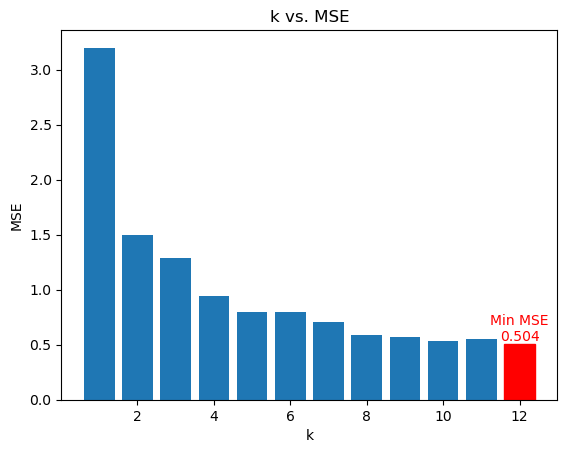

In [45]:
import matplotlib.pyplot as plt

mse_values = [pred_result[k]["mse"] for k in k_list]

bars = plt.bar(k_list, mse_values)

min_mse_index = mse_values.index(min(mse_values))
bars[min_mse_index].set_color('red')

min_mse_value = mse_values[min_mse_index]
plt.text(min_mse_index + 1, min_mse_value, f'Min MSE\n{min_mse_value:.3f}', ha='center', va='bottom', color='red')

plt.xlabel('k')
plt.ylabel('MSE')
plt.title('k vs. MSE')

plt.show()

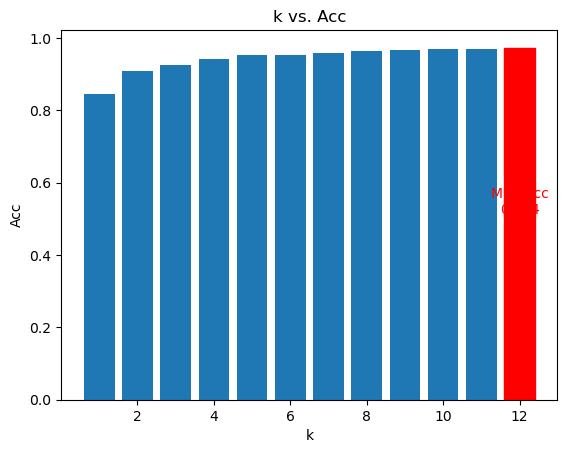

In [47]:
import matplotlib.pyplot as plt

accuracy_values = [pred_result[k]["accuracy"] for k in k_list]

bars = plt.bar(k_list, accuracy_values)

max_accuracy_index = accuracy_values.index(max(accuracy_values))
bars[max_accuracy_index].set_color('red')

max_accuracy_value = mse_values[max_accuracy_index]
plt.text(max_accuracy_index + 1, max_accuracy_value, f'Max Acc\n{max_accuracy_value:.3f}', ha='center', va='bottom', color='red')

plt.xlabel('k')
plt.ylabel('Acc')
plt.title('k vs. Acc')

plt.show()

In [49]:
for k, data in pred_result.items():
    print(f"k:{k},{data['TP_counts']}/{data['TP_counts']+data['FP_counts']}, Acc:{data['accuracy']}")

k:1,6166/7291, Acc:0.8457001783020162
k:2,6628/7291, Acc:0.9090659717459882
k:3,6749/7291, Acc:0.925661774790838
k:4,6864/7291, Acc:0.9414346454532986
k:5,6944/7291, Acc:0.9524070772184885
k:6,6945/7291, Acc:0.9525442326155534
k:7,6989/7291, Acc:0.9585790700864079
k:8,7024/7291, Acc:0.9633795089836785
k:9,7041/7291, Acc:0.9657111507337813
k:10,7058/7291, Acc:0.9680427924838843
k:11,7069/7291, Acc:0.9695515018515979
k:12,7093/7291, Acc:0.9728432313811548


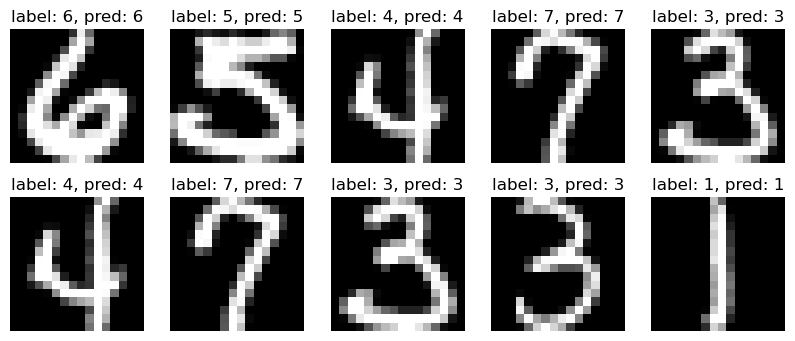

In [51]:
fig, axes = plt.subplots(2, 5, figsize=(10, 4), gridspec_kw={'height_ratios': [1, 1]})

for i in range(2):
    for j in range(5):
        index = i * 2 + j
        target_index = pred_detail_result[12]["TP_list"][:10][index]

        image = TRAIN_X[target_index].reshape((16, 16))
        label = TRAIN_Y[target_index]
        pred = pred_result[12]["pred_list"][target_index]

        axes[i, j].imshow(image, cmap='gray')
        axes[i, j].set_title(f"label: {label}, pred: {pred}")
        axes[i, j].axis('off')

plt.show()